# GW Legacy Object and Target Identification

Using the BGS DR9 targeting data, identify all objects within the 90% credible interval of a GW alert angular reconstruction.

We are not using the Legacy Survey for target selection, since the BGS selection serves our needs, but use of the DR9 imaging data is demonstrated in an [equivalent DR8 notebook posted on GitHub](https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr8.ipynb).

### A Note on Target Selection using Luminosity Distance

For surveying potential GW hosts, it is possible to use the DR8/DR9 photo-z catalogs to remove targets outside the central 90% C.I. of the GW luminosity distance. However, since this requires an assumed cosmology, this kind of selection is not appropriate if the goal is to produce a dark siren measurement of $H_0$. (It would be fine if the only goal is to find a GW electromagnetic counterpart and **not** measure $H_0$.) We omit the use of photo-z selection in this notebook, but it is demonstrated in [an equivalent DR8 target notebook posted on GitHub](https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr8.ipynb).

### Notebook Dependencies

This notebook depends on several external resources:
1. A python module `gw_skymap.py` used to compute 90% contours and plot skymaps.
2. A GW FITS file based on the Bayestar or LALInference reconstructions.
3. Optionally, a set of FITS files identifying the DESI footprint (just for plotting).

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column, join, hstack, vstack, unique
from scipy.stats import norm

import logging
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_mollmap, plot_cartmap

from desitarget import io, cuts
from desitarget.targetmask import desi_mask, bgs_mask

In [2]:
mpl.rc('font', size=12)

## Access GW190412 Angular Reconstruction

Grab DR8 objects inside the 90% contour of a GW alert.

In [3]:
gwfile = 'GW190412_skymap.fits.gz'

### Plot Contours and SV Fields

In [4]:
def draw_sv(ra_min, ra_max, dec_min, dec_max, color='g'):
    """Given the bounding box of an SV field, plot it using current HEALPix projection.
    
    Parameters
    ----------
    ra_min: float
        Minimum RA of the SV bounding box, in degrees.
    ra_max: float
        Maximum RA of the SV bounding box, in degrees.
    dec_min: float
        Minimum Dec of the SV bounding box, in degrees.
    dec_max: float
        Maximum Dec of the SV bounding box, in degrees.
    """
    y = np.arange(dec_min, dec_max+0.1, 0.1)
    x = np.full_like(y, ra_min)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)
    
    x = np.full_like(y, ra_max)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)
    
    x = np.arange(ra_min, ra_max+0.1, 0.1)
    y = np.full_like(x, dec_max)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)
    
    y = np.full_like(x, dec_min)
    hp.projplot(x, y, lonlat=True, color=color, lw=1, ms=0)

### Full-Sky Map, Mollweide Projection

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

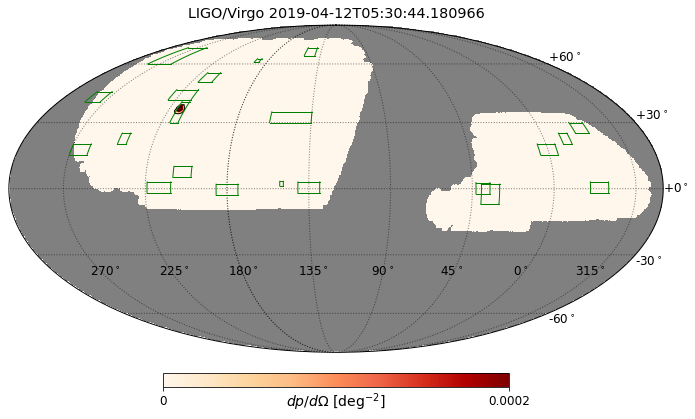

In [5]:
fig = plot_mollmap(gwfile, rot=120)

show_sv = True
if show_sv:
    draw_sv(187,191,61,63)    # NGC, 187 < α < 191, 61 < δ < 63 4 BASS+MzLS HDF-N
    draw_sv(210,220,50,55)    # NGC, 210 < α < 220, 50 < δ < 55 31 BASS+MzLS DEEP2/EGS, SNLS-D3 and HSC photo-z
    draw_sv(215,230,41,46)    # NGC, 215 < α < 230, 41 < δ < 46 56 BASS+MzLS HSC photo-z
    draw_sv(260,280,60,70)    # NGC, 260 < α < 280, 60 < δ < 70 92 BASS+MzLS North Ecliptic Pole, a Euclid deep field
    draw_sv(129,141,-2,3)     # NGC, 129 < α < 141, −2 < δ < 3 60 DECaLS GAMA G09
    draw_sv(149,151,1.2,3.2)  # NGC, 149 < α < 151, 1.2 < δ < 3.2 4 DECaLS COSMOS
    draw_sv(174,186,-3,2)     # NGC, 174 < α < 186, −3 < δ < 2 60 DECaLS GAMA G12
    draw_sv(211,224,-2,3)     # NGC, 211 < α < 224, −2 < δ < 3 65 DECaLS GAMA G15
    draw_sv(-5,5,15,20)       # SGC, −5 < α < 5, 15 < δ < 20 24 DECaLS
    draw_sv(30,40,-7,2)       # SGC, 30 < α < 40, −7 < δ < 2 65 DES Stripe 82/HSC, GAMA 02, DEEP2, XMM-LSS
    draw_sv(330,340,-2,3)     # SGC, 330 < α < 340, −2 < δ < 3 50 DES Stripe 82 , and HSC photo-z
    # Overlapping Imaging
    draw_sv(135,160,30,35)    # NGC, 135 < α < 160, 30 < δ < 35 104 BASS+MzLS and DECaLS
    draw_sv(35.3,43,-2.3,2.7) # SGC, 35.3 < α < 43.0, −2.3 < δ < 2.7 39 BASS+MzLS and DES Stripe 82, and HSC photo-z
    # Bad Seeing Conditions
    draw_sv(215,220,30,40)    # NGC, 215 < α < 220, 30 < δ < 40 40 BASS+MzLS AGES
    # Strong Dust Extinction
    draw_sv(140,150,65,70)    # NGC, 140 < α < 150, 65 < δ < 70 19 BASS+MzLS
    draw_sv(240,245,20,25)    # NGC, 240 < α < 245, 20 < δ < 25 23 DECaLS
    draw_sv(345,350,20,25)    # SGC, 345 < α < 350, 20 < δ < 25 23 DECaLS
    # High Stellar Density
    draw_sv(200,210,5,10)     # NGC, 200 < α < 210, 5 < δ < 10 49 DECaLS Sagittarius Stream
    # High Stellar Density and Strong Dust Extinction
    draw_sv(273,283,40,45)    # NGC, 273 < α < 283, 40 < δ < 45 37 BASS+MzLS Close to Galactic Plane
    draw_sv(260,270,15,20)    # NGC, 260 < α < 270, 15 < δ < 20 47 DECaLS Close to Galactic Plane
    draw_sv(332,340,25,30)    # SGC, 332 < α < 340, 25 < δ < 30 36 DECaLS Close to Galactic Plane

fig.savefig('GW190412_desi_footprint.png', dpi=120)

### Zoom-in to Localization Region

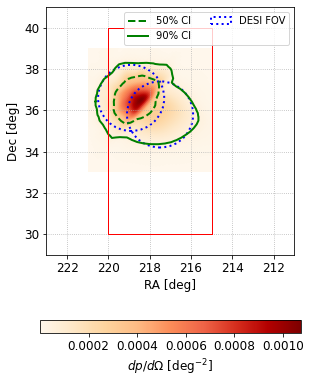

In [6]:
# fig = plot_cartmap(gwfile, tile_ra=[219.1,217.1,219.3,217.1], tile_dec=[37.0,36.75,35.8,35.55], angsize=3)
fig = plot_cartmap(gwfile, tile_ra=[218.9,217.5], tile_dec=[36.6,35.8], angsize=3)

if show_sv:
#     draw_sv(215,220,30,40, color='r')    # NGC, 215 < α < 220, 30 < δ < 40 40 BASS+MzLS AGES
    ax = fig.gca()
    ax.plot([215,215,220,220,215], [30,40,40,30,30], lw=1, color='r', label='SV field')
    ax.set(xlim=(223, 211), ylim=(29,41))
    
fig.savefig('GW190412_desi_tiles.png', dpi=120)

## DR9 Targets

Extract DR9 targets within the central 90% C.I. of the reconstructed GW event.

In [7]:
# Load sample of resolved DR9 target catalog using HEALPixels above threshold in the GW map.
# Get list of pixels above threshold defined by level.
gwmap = hp.read_map(gwfile)
npix = len(gwmap)
nside = hp.npix2nside(npix)
levels = [0.50, 0.90]
lev50, lev90 = compute_quantiles(levels, gwmap)

pixels = hp.ring2nest(nside, np.arange(npix))
pix90 = pixels[gwmap > lev90]

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

In [8]:
# Area of 90% C.I.
area = 4*np.pi*len(pix90)/npix * (180/np.pi)**2
print('A = {:.1f} deg^2'.format(area))

A = 11.9 deg^2


In [9]:
hpdirnames = ['/global/project/projectdirs/desi/target/catalogs/dr9m/0.44.0/targets/main/resolve/bright',
              '/global/project/projectdirs/desi/target/catalogs/dr9m/0.44.0/targets/main/resolve/dark']
readcols = ['TARGETID', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID',
            'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH',
            'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET',
            'FLUX_G', 'FLUX_R', 'FLUX_Z',
            'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z']

targlist90 = None
for hpdirname in hpdirnames:
    if targlist90 is None:
        targlist90 = Table(io.read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90, columns=readcols))
    else:
        targlist90 = vstack(targlist90, Table(io.read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90, columns=readcols)))
        
# targlist90.rename_column('BRICK_OBJID', 'OBJID')
targlist90 = unique(targlist90)

In [10]:
targlist90

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,REF_EPOCH,PMRA,PMDEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64
517203,2175p342,50,217.38947442578856,34.373279599411276,9.209506,25.844042,45.523174,7.115383,19.967438,35.17179,2015.5,5.8729486,-14.578648,39632966418169906,2305843009213693952,0,17
517203,2175p342,1397,217.50147266200636,34.36353835642189,3.6192565,11.106136,23.332632,1.6412047,5.0362396,10.5805235,0.0,0.0,0.0,39632966418171253,1152921504606846976,257,0
517203,2175p342,1592,217.5175800107535,34.35568071560189,85.85435,137.67401,154.96953,66.67784,106.92302,120.3554,2015.5,-4.519282,-3.4190521,39632966418171448,2305843009213693952,0,768
517203,2175p342,2322,217.57769729282273,34.37483186063451,7.708763,12.43162,18.599564,2.5472379,4.1078305,6.145929,0.0,0.0,0.0,39632966418172178,1152921504606846976,257,0
517203,2175p342,3358,217.6602564101732,34.373282429926974,15.6081915,53.855896,103.35144,4.094833,14.129176,27.114407,0.0,0.0,0.0,39632966418173214,1152921504606846976,514,0
517203,2175p342,3531,217.67715979526403,34.35703072234191,4.1758795,10.125961,19.851458,1.985189,4.813823,9.437268,0.0,0.0,0.0,39632966418173387,1152921504606846976,257,0
517204,2178p342,104,217.69566892501612,34.3520748416281,31.78339,69.27625,99.889946,24.668577,53.768543,77.52927,2015.5,3.3853865,-11.311127,39632966422364264,2305843009213693952,0,17
517204,2178p342,111,217.69661710217235,34.348338429426946,34.00928,43.198185,44.267803,26.459282,33.60826,34.44043,2015.5,-7.2976303,0.7645024,39632966422364271,2305843017803628544,0,768
517204,2178p342,130,217.69832271491796,34.327466509297416,14.428124,28.261665,46.62925,6.846612,13.411076,22.127089,0.0,0.0,0.0,39632966422364290,1152921504606846976,514,0


### Select Bright Targets

Apply the standard BGS bit mask and magnitude cut.

In [11]:
bgs_bright = (targlist90['BGS_TARGET'] & bgs_mask.mask('BGS_BRIGHT')) != 0
print('{:d} / {:d} = {:.1f}% are BGS bright targets'.format(np.sum(bgs_bright), len(targlist90), 1e2*np.sum(bgs_bright)/len(targlist90)))
btarglist90 = targlist90[bgs_bright]

8754 / 25659 = 34.1% are BGS bright targets


### Plot Bright Targets in GW Contour

Plot all BGS bright targets in the 90% region of the GW event, color coded using the relative angular probability.

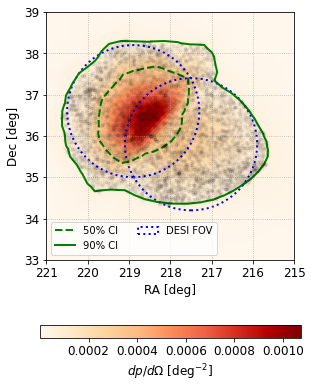

In [12]:
fig = plot_cartmap(gwfile,
                   tile_ra=[218.9,217.5], tile_dec=[36.6,35.8],
                   targ_ra=btarglist90['RA'], targ_dec=btarglist90['DEC'],
                   angsize=3)
fig.savefig('GW190412_bgsbright_targets.png', dpi=120)

## Write Secondary Target List

Dump output list to ASCII file.

In [13]:
output = btarglist90['RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH']
output['OVERRIDE'] = np.full_like(output['RA'], False, dtype=bool)
output.write('GW190412_dr9m_sec_targets.txt', format='ascii', overwrite=True)